## Import statements

In [2]:
import copy
import random
import time
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import models

from util.dataset_util import DatasetUtil
from util.imagenet_utk import ImagenetUtk
from util.imagenet_vgg import ImagenetVgg

# Use CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Using %s for training/validating the model" % device)
torch.manual_seed(0)


# TODO: Fix
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32 + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)


Using cuda:0 for training/validating the model


## Data Preprocessing

In [4]:
# Parameter settings for batching
batch_size = 128
shuffle = True

# Use this line if you're executing for the first time
# data_utility = DatasetUtil(base_dir="./datasets", total_class_count=10, img_size=64, train_img_count=500,
#                            vgg_download=True)
# data_utility.save_all_json()

data_utility = DatasetUtil(base_dir="./datasets", total_class_count=4, img_size=64, train_img_count=500,
                           load_from_json=False)
data_utility.save_all_json()

# Load data for Tiny ImageNet + UTKFace
utk_datasets = {'train': ImagenetUtk(du=data_utility, base_dir="./datasets", image_size=64),
                'val': ImagenetUtk(du=data_utility, base_dir="./datasets", image_size=64, validation=True)}
utk_dataloaders = {'train': DataLoader(dataset=utk_datasets['train'], batch_size=batch_size,
                                       shuffle=shuffle, num_workers=7, worker_init_fn=seed_worker),
                   'val': DataLoader(dataset=utk_datasets['val'], batch_size=batch_size,
                                     shuffle=shuffle, num_workers=7, worker_init_fn=seed_worker)}

# Load data for Tiny ImageNet + VGG
vgg_datasets = {'train': ImagenetVgg(du=data_utility, base_dir="./datasets", image_size=64),
                'val': ImagenetVgg(du=data_utility, base_dir="./datasets", image_size=64, validation=True)}
vgg_dataloaders = {'train': DataLoader(dataset=vgg_datasets['train'], batch_size=batch_size,
                                       shuffle=shuffle, num_workers=7, worker_init_fn=seed_worker),
                   'val': DataLoader(dataset=vgg_datasets['val'], batch_size=batch_size,
                                     shuffle=shuffle, num_workers=7, worker_init_fn=seed_worker)}

# this classes list will contain class names of items[0] to [9] in string
class_names = utk_datasets['train'].get_class_names()

05/29/2021 07:00:17 PM - INFO: Resized images saved.
05/29/2021 07:00:17 PM - INFO: int2name saved as: ./datasets/modified_datasets/int2name.json
05/29/2021 07:00:17 PM - INFO: Tiny ImageNet id2int saved as: ./datasets/modified_datasets/imagenet/id2int.json
05/29/2021 07:00:18 PM - INFO: Tiny ImageNet id2name saved as: ./datasets/modified_datasets/imagenet/id2name.json
05/29/2021 07:00:18 PM - INFO: Tiny ImageNet training list saved as: ./datasets/modified_datasets/imagenet/train.json
05/29/2021 07:00:18 PM - INFO: Tiny ImageNet validation list saved as: ./datasets/modified_datasets/imagenet/validation.json
05/29/2021 07:00:18 PM - INFO: UTKFace training list saved as: ./datasets/modified_datasets/utk/train.json
05/29/2021 07:00:18 PM - INFO: UTKFace validation list saved as: ./datasets/modified_datasets/utk/validation.json
05/29/2021 07:00:18 PM - INFO: VGG training list saved as: ./datasets/modified_datasets/vgg/train.json
05/29/2021 07:00:18 PM - INFO: VGG validation list saved as: 

## Dataset preview

In [5]:
def info_data(image_datasets: dict, dataloaders: dict) -> None:
    """
    Prints info. about datasets/dataloaders; uncomment if necessary
    :return: None
    """
    print('Number of classes: %s' % len(class_names))
    print('Class names: %s' % class_names)
    print('Length of training dataset: %s' % len(image_datasets['train']))
    print('Length of validation dataset: %s' % len(image_datasets['val']))
    print('Batch size: %s' % batch_size)
    print('Number of batches in the training dataloader: %s' % len(dataloaders['train']))
    print('Number of batches in the training dataloader: %s' % len(dataloaders['val']))
    print('Device: %s\n' % device)


print("UTKFace dataset statistics")
info_data(utk_datasets, utk_dataloaders)
print("VGG Face dataset statistics")
info_data(vgg_datasets, vgg_dataloaders)

UTKFace dataset statistics
Number of classes: 4
Class names: ['water tower', 'orangutan, orang, orangutang, Pongo pygmaeus', 'wooden spoon', 'face']
Length of training dataset: 2000
Length of validation dataset: 200
Batch size: 128
Number of batches in the training dataloader: 16
Number of batches in the training dataloader: 2
Device: cuda:0

VGG Face dataset statistics
Number of classes: 4
Class names: ['water tower', 'orangutan, orang, orangutang, Pongo pygmaeus', 'wooden spoon', 'face']
Length of training dataset: 2000
Length of validation dataset: 200
Batch size: 128
Number of batches in the training dataloader: 16
Number of batches in the training dataloader: 2
Device: cuda:0



In [18]:
def image_show(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


def get_preview(dataloaders: dict):
    """
    Preview 64 images in training dataset
    :param dataloaders: Dataloader dictionary to use to print images
    :return: None
    """
    # Get the first batch of training data
    inputs, classes = list(dataloaders['train'])[0]

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs[:64])

    image_show(out, title="preview")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


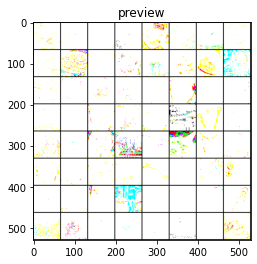

In [19]:
get_preview(dataloaders=utk_dataloaders)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


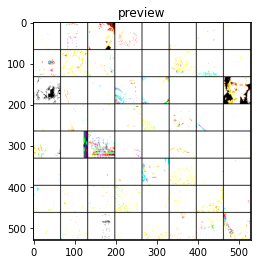

In [20]:
get_preview(dataloaders=vgg_dataloaders)

## Model Training

In [3]:
# Parameters
EPOCH = 25
LEARNING_RATE = 0.001
SGD_MOMENTUM = 0.9
SGD_WEIGHT_DECAY = 0.0001
LR_DECAY_STEP_SIZE = 7
LR_DECAY_FACTOR = 0.1


def train_model(model_ft: Any, dataloaders, image_datasets):
    def _train_model(model: Any, criterion, optimizer, scheduler, dl, img_datasets):
        since = time.time()

        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0

        for epoch in range(EPOCH):
            print('Epoch {}/{}'.format(epoch, EPOCH - 1))
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for imgs, labels in dl[phase]:
                    # print('Iterating ', labels, '...')
                    torch.cuda.empty_cache()  # clean up cache
                    #print(torch.cuda.memory_summary(device=device, abbreviated=False))
                    imgs = imgs.float().to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(imgs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * imgs.size(0)
                    running_corrects += torch.eq(preds, labels.data).sum()
                if phase == 'train':
                    scheduler.step()
                dataset_size = len(img_datasets[phase])
                epoch_loss = running_loss / dataset_size
                epoch_acc = running_corrects.double() / dataset_size

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

            print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
        model.load_state_dict(best_model_wts)
        return model

    num_ftrs = model_ft.fc.in_features

    # TODO: Here the size of each output sample is set to 2 it is the number of classes.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model_ft.fc = nn.Linear(num_ftrs, len(class_names))

    model_ft = model_ft.to(device)

    loss_fn = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=LEARNING_RATE, weight_decay=SGD_WEIGHT_DECAY,
                             momentum=SGD_MOMENTUM)

    # Decay LR by a factor of 0.1 every 7 epochs
    # TODO: Perhaps we can consider ReduceLROnPlateau instead
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=LR_DECAY_STEP_SIZE, gamma=LR_DECAY_FACTOR)

    return _train_model(model_ft, loss_fn, optimizer_ft, exp_lr_scheduler,
                        dl=dataloaders, img_datasets=image_datasets)

# model_arch = models.resnet50()

In [4]:
utk_model_ft = train_model(models.resnet50(), dataloaders=utk_dataloaders, image_datasets=utk_datasets)

Epoch 0/24
----------
train Loss: 1.3965 Acc: 0.2900
val Loss: 2.1036 Acc: 0.3250

Epoch 1/24
----------
train Loss: 1.3690 Acc: 0.3215
val Loss: 2.6802 Acc: 0.3350

Epoch 2/24
----------
train Loss: 1.3315 Acc: 0.3640
val Loss: 1.4389 Acc: 0.4050

Epoch 3/24
----------
train Loss: 1.1864 Acc: 0.4710
val Loss: 1.1834 Acc: 0.4750

Epoch 4/24
----------
train Loss: 1.0827 Acc: 0.5335
val Loss: 1.0845 Acc: 0.5450

Epoch 5/24
----------
train Loss: 1.0205 Acc: 0.5675
val Loss: 1.0597 Acc: 0.5350

Epoch 6/24
----------
train Loss: 0.9514 Acc: 0.5965
val Loss: 1.0099 Acc: 0.5700

Epoch 7/24
----------
train Loss: 0.9037 Acc: 0.6435
val Loss: 0.9748 Acc: 0.5400

Epoch 8/24
----------
train Loss: 0.8757 Acc: 0.6630
val Loss: 0.9509 Acc: 0.5750

Epoch 9/24
----------
train Loss: 0.8642 Acc: 0.6630
val Loss: 0.9450 Acc: 0.5700

Epoch 10/24
----------
train Loss: 0.8479 Acc: 0.6725
val Loss: 0.9352 Acc: 0.5950

Epoch 11/24
----------
train Loss: 0.8400 Acc: 0.6785
val Loss: 0.9321 Acc: 0.5800

Ep

In [ ]:
vgg_model_ft = train_model(models.resnet50(), dataloaders=utk_dataloaders, image_datasets=utk_datasets)

## Model Visualization

In [34]:
def visualize_model(model, dataloaders: dict, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    # fig = plt.figure()

    with torch.no_grad():
        for i, (imgs, labels) in enumerate(dataloaders['val']):
            imgs = imgs.float().to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            for j in range(imgs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                # TODO: Using .get_class_names() for actual prediction is discouraged as index may not be correct.
                ax.set_title(('predicted:' + class_names[preds[j]] +
                              '\n answer:' + class_names[labels.cpu().numpy()[images_so_far - 1]]))
                image_show(imgs.int().cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

64
64
64
64
64
64
64
64
64
64


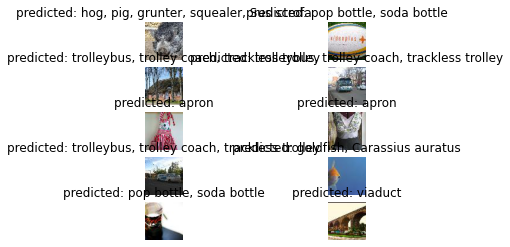

In [35]:
# Visualize utk models
visualize_model(utk_model_ft, utk_dataloaders)
# Visualize vgg models
visualize_model(vgg_model_ft, vgg_dataloaders)